Dataset Link : https://www.kaggle.com/datasets/jangedoo/utkface-new

**This model predicts the age and gender of a Person by Image input**

Tested on Python 3.9.13

In [ ]:
!pip install tensorflow==2.12.0 pandas pydot

In [1]:
import tensorflow

tensorflow.__version__

'2.16.1'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

In [ ]:
import os
import pandas as pd
import shutil


cwd = os.getcwd()

dataset_name = os.path.basename(path.rstrip('/'))
destination = os.path.join(cwd, dataset_name)

shutil.move(path, destination)

print("Dataset moved to:", destination)

Model Building

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
print("GPU Available:", tf.test.is_gpu_available())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU Available: False


In [18]:
folder_path = "1/utkface_aligned_cropped/UTKFace"

In [19]:
import os
import pandas as pd

age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [20]:
len(img_path)

23708

In [21]:
df = pd.DataFrame({'age': age, 'gender':gender, "img_path":img_path})
df.head()

,age,gender,img_path
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [22]:
train_df = df.sample(frac=1, random_state=0).iloc[:20000]
test_df = df.sample(frac=1, random_state=0).iloc[20000:]

In [23]:
train_df.shape

(20000, 3)

In [24]:
test_df.shape

(3708, 3)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col = 'img_path',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')

test_generator  = train_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col = 'img_path',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


**Transfer Learning approach**

In [27]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [28]:
vgg16 = VGG16(include_top=False, input_shape=(200,200,3))

In [29]:
vgg16.trainable = False

output = vgg16.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(512, activation='relu')(dense1)
dense4 = Dense(512, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

In [30]:
model = Model(inputs = vgg16.input, outputs = [output1, output2])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [35]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.compile(
    optimizer='adam', 
    loss={'age':'mae', 'gender':'binary_crossentropy'}, 
    metrics={'age':'mae', 'gender':'accuracy'}, 
    loss_weights={'age':0.5, 'gender':0.5}
)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop_age = EarlyStopping(
    monitor='val_age_mae',
    patience=2,                  # Stop if no improvement for 2 consecutive epochs
    restore_best_weights=True,   # Restore the best model weights
    mode='min',                  # Monitor the validation loss
    verbose=1
)

early_stop_gender = EarlyStopping(
    monitor='val_gender_loss',
    patience=2,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [40]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    batch_size=32,
    callbacks=[early_stop_age, early_stop_gender]
)

Epoch 1/10
625/625 [==============================] - 2394s 4s/step - loss: 59.3511 - age_loss: 10.4820 - gender_loss: 0.4936 - age_mae: 10.4820 - gender_accuracy: 0.7617 - val_loss: 49.8364 - val_age_loss: 9.4448 - val_gender_loss: 0.4080 - val_age_mae: 9.4448 - val_gender_accuracy: 0.8180
Epoch 2/10
625/625 [==============================] - 2201s 4s/step - loss: 51.8143 - age_loss: 9.2736 - gender_loss: 0.4297 - age_mae: 9.2736 - gender_accuracy: 0.7977 - val_loss: 49.0961 - val_age_loss: 9.8234 - val_gender_loss: 0.3967 - val_age_mae: 9.8234 - val_gender_accuracy: 0.8163
Epoch 3/10
625/625 [==============================] - 1755s 3s/step - loss: 48.0406 - age_loss: 8.8405 - gender_loss: 0.3960 - age_mae: 8.8405 - gender_accuracy: 0.8150 - val_loss: 46.2913 - val_age_loss: 8.8508 - val_gender_loss: 0.3782 - val_age_mae: 8.8508 - val_gender_accuracy: 0.8242
Epoch 4/10
625/625 [==============================] - 1857s 3s/step - loss: 46.5430 - age_loss: 8.6328 - gender_loss: 0.3829 - a

In [42]:
model.save("Age_Gender_Classification_model.h5")

In [43]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'age_loss', 'gender_loss', 'age_mae', 'gender_accuracy', 'val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_mae', 'val_gender_accuracy'])


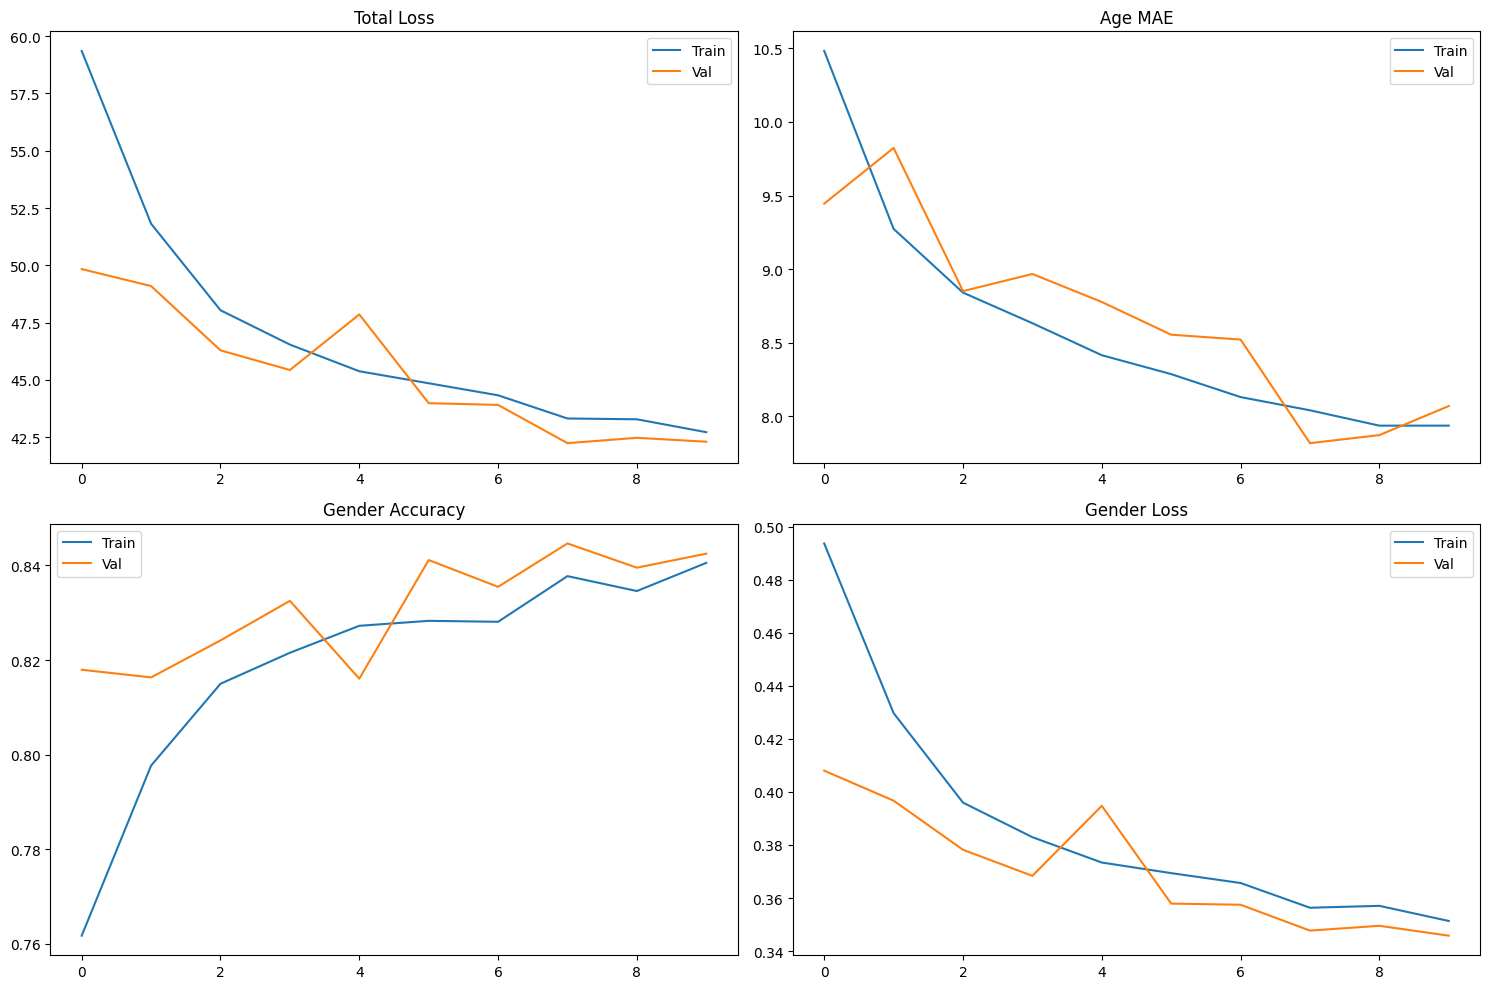

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Total Loss
axs[0, 0].plot(history.history['loss'], label='Train')
axs[0, 0].plot(history.history['val_loss'], label='Val')
axs[0, 0].set_title('Total Loss')
axs[0, 0].legend()

# Age MAE
axs[0, 1].plot(history.history['age_mae'], label='Train')
axs[0, 1].plot(history.history['val_age_mae'], label='Val')
axs[0, 1].set_title('Age MAE')
axs[0, 1].legend()

# Gender Accuracy
axs[1, 0].plot(history.history['gender_accuracy'], label='Train')
axs[1, 0].plot(history.history['val_gender_accuracy'], label='Val')
axs[1, 0].set_title('Gender Accuracy')
axs[1, 0].legend()

# Gender Loss
axs[1, 1].plot(history.history['gender_loss'], label='Train')
axs[1, 1].plot(history.history['val_gender_loss'], label='Val')
axs[1, 1].set_title('Gender Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### **Sample Prediction**

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
model = load_model('Age_Gender_Classification_model.h5')

In [7]:
image_path = "images\\Anushka Sharma.jpg"

img = image.load_img(image_path, target_size=(200, 200))  # Resize to match model input
img_array = image.img_to_array(img)  # Convert to array
img_array = img_array / 255.0  # Normalize pixel values (same as training)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

In [8]:
age_pred, gender_pred = model.predict(img_array)

1/1 [==============================] - 0s 100ms/step


In [9]:
predicted_age = age_pred[0][0]  # Age is a single value (linear output)
gender_prob = gender_pred[0][0]  # Sigmoid output (probability)
predicted_gender = "Female" if gender_prob > 0.5 else "Male"  # Gender threshold at 0.5
gender_confidence = gender_prob * 100 if gender_prob > 0.5 else (1 - gender_prob) * 100  # Confidence as percentage

# Display results
print(f"Predicted Age: {int(predicted_age)} years")
print(f"Predicted Gender: {predicted_gender}, Confidence: {gender_confidence:.2f}%")

Predicted Age: 38 years
Predicted Gender: Female, Confidence: 71.34%


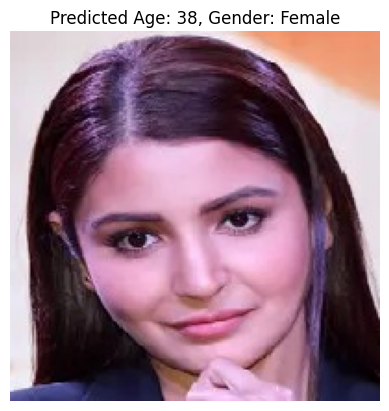

In [10]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted Age: {int(predicted_age)}, Gender: {predicted_gender}")
plt.axis('off')
plt.show()